In [1]:
import pymongo


myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["sentipeople"]
mycol = mydb["tweets_data"]
mysenti=mydb["senti_data"]
mysenti.create_index("tweet",unique='True')
final_data = mycol.find({}, {"_id":0})

def is_tweet_sentiment_computed(tweet):
    for x in mysenti.find({"tweet":tweet},{ "_id": 0}):
        return (x['sentiment'])
    return None
def save_tweet_sentiment(tweet,sentiment):
    res=mysenti.insert_one({"tweet":tweet, "sentiment":sentiment})


In [2]:
from pycorenlp import StanfordCoreNLP

nlp_wrapper = StanfordCoreNLP('http://localhost:9000')

In [3]:
from datetime import date
from datetime import timedelta
import dateutil.parser
count_neutral=0
count_negative=0
count_positive=0
pos_tweets={}
neu_tweets={}
neg_tweets={}
count_stanford=0
for tweet in final_data:
    my_date=tweet['date']
    count_stanford+=1
    DateFormat = '%Y-%m-%d'
    mydt = my_date
    a=dateutil.parser.parse(mydt)
    f_date=a.strftime(DateFormat)
#     if count_stanford%100==0:
#         print("at record {}".format(count_stanford))
    cached_sentiment=is_tweet_sentiment_computed(tweet["tweet"])
    if cached_sentiment is None:
    
        annot_tweet = nlp_wrapper.annotate(tweet["tweet"],
            properties={
                'annotators': 'sentiment',
                'outputFormat': 'json',
                'timeout': 10000,
            })
        save_tweet_sentiment(tweet["tweet"],annot_tweet)
    else:
        annot_tweet=cached_sentiment
#         print(type(annot_tweet))
    try:   
        count=len(annot_tweet['sentences'])
    except Exception as e:
        continue
    for i in range(count):
        senti=annot_tweet['sentences'][i]['sentiment']
        if senti=='Neutral':
            neu_tweets[f_date]=neu_tweets.get(f_date,0)+1
            count_neutral+=1
        elif senti=='Negative':
            neg_tweets[f_date]=neg_tweets.get(f_date,0)+1
            count_negative+=1
        else:
            pos_tweets[f_date]=pos_tweets.get(f_date,0)+1
            count_positive+=1


In [4]:
print('neutral count is {}'.format(count_neutral))
print('negative count is {}'.format(count_negative))
print('positive count is {}'.format(count_positive))

neutral count is 26531
negative count is 7483
positive count is 2891


## Plotting Bar Graph for number of negative,neutral and positive tweets.

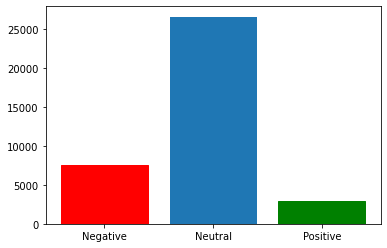

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
x_axis = ['Negative', 'Neutral', 'Positive']
y_axis = [count_negative,count_neutral,count_positive]
barlist=plt.bar(x_axis,y_axis)
barlist[0].set_color('r')
barlist[2].set_color('g')
plt.show()

## Plotting Line Graph for people's sentiment over the span of time.

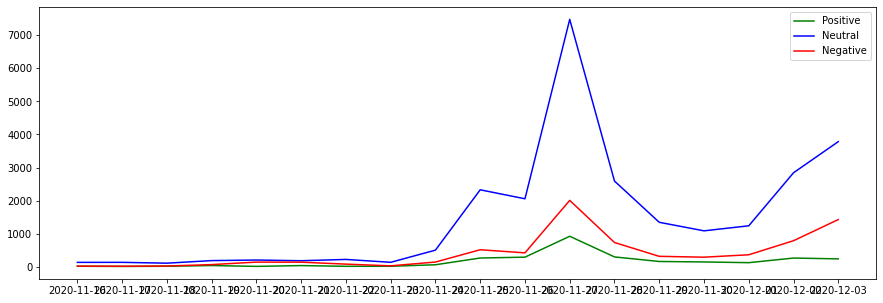

In [6]:
fig = plt.figure(figsize=(15,5))

x_axis2=sorted(list(set(list(pos_tweets.keys())+list(neu_tweets.keys())+list(neg_tweets.keys()))))

pos_count = [pos_tweets.get(d,0) for d in x_axis2]
neu_count= [neu_tweets.get(d,0) for d in x_axis2]
neg_count= [neg_tweets.get(d,0) for d in x_axis2]

barlist=plt.plot(x_axis2,pos_count,label='Positive',color='green')
barlist=plt.plot(x_axis2,neu_count,label='Neutral',color='blue')
barlist=plt.plot(x_axis2,neg_count,label='Negative',color='red')
plt.legend()
plt.show()

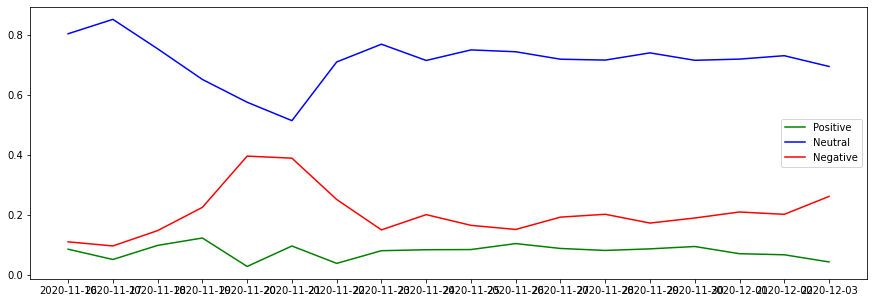

In [7]:
import numpy as np
sum_count=np.array(pos_count)+np.array(neu_count)+np.array(neg_count)
# print(sum_count)
pos_pcount = pos_count/sum_count
neu_pcount= neu_count/sum_count
neg_pcount= neg_count/sum_count
fig = plt.figure(figsize=(15,5))


barlist=plt.plot(x_axis2,pos_pcount,label='Positive',color='green')
barlist=plt.plot(x_axis2,neu_pcount,label='Neutral',color='blue')
barlist=plt.plot(x_axis2,neg_pcount,label='Negative',color='red')
plt.legend()
plt.show()